# Detect lithological boundaries using Quadrant Scan

In this notebook, we will test the Quadrant Scan technique to analyse a multivariate, noisy, and nonstationary data set.

The data set includes petrophysical profiles from well_log measures. Namely, DTCO, ECGR, HART, PEFZ, RHOZ, TNPH.
The data includes 7688 depth samples. Refering to the following petrophysical profiles density, electrical resistivity, sonic velocity, natural radioactivity, mean atomic number and neutron porosity

The idea of this exercise is to use the Quadrant Scan to detect transision in the data profiles to identify the lithological boundaries.

# Import libraries and define functions

In [36]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import scipy

from scipy.stats import pearsonr
import scipy.sparse as sparse
from IPython.display import Latex
from matplotlib.pyplot import imshow

from numba import jit
from __future__ import division
%matplotlib inline

##Recurrence Plot matrix
## This function is constructing the recurrence plot matrix based on the threshold alpha

def RecurrenceMatrix(x, alpha):
    
    distance = scipy.spatial.distance.pdist(x, 'euclidean')
    #distance = scipy.spatial.distance.pdist(embedded, 'seuclidean',V=None)
    #distance = scipy.spatial.distance.pdist(embedded, 'canberra')
    #distance = scipy.spatial.distance.pdist(embedded, 'mahalanobis', VI=None)
    distance = scipy.spatial.distance.squareform(distance)
    
    threshold = alpha*(distance.mean()+3*distance.std())
    
    #Recurrence Plot Matrix
    RM=np.array(distance<=threshold,dtype='int')
    
    return RM



##Quadrant Scan
## This function is employing the Quadrant Scan technique on input x (univariate or multivariate) using:
## the recuurence plot threshold alpha, the weighting parameters m1 and m2.

def WeightQS2(x, alpha, m1, m2):
    
    RM=RecurrenceMatrix(x, alpha)
    
    qs=np.zeros(len(x))
    for ii in range(1, len(x)):
        weightp = 0.5*(1-np.tanh((np.arange(1,ii+1)-m1)/m2))
        weightp = weightp[::-1]
        weightf = 0.5*(1-np.tanh((np.arange(1,len(x)-ii+1)-m1)/m2))
        
        weightpp = weightp[:,None]*weightp[None,:]
        weightpp = weightpp/weightpp[-1,-1]
        
        weightff = weightf[:,None]*weightf[None,:]
        weightff = weightff/weightff[0,0]
        
        weightpf=weightp[:,None]*weightf[None,:]
        weightpf /= weightpf[-1,0]
        
        weightfp=weightf[:,None]*weightp[None,:]
        weightfp /= weightfp[0,-1]
       
        pp =  RM[:ii,:ii] * weightpp
        
        ff = RM[ii-1:-1,ii-1:-1] * weightff
        
        pf = RM[:ii,ii-1:-1] * weightpf
        
        fp = RM[ii-1:-1,:ii] * weightfp
        
        qs1 = np.sum(pp)+np.sum(ff)
        qs2 = np.sum(pf)+np.sum(fp)
        qs[ii] = qs1/(qs1+qs2)
        
    return qs



# Reading the data file

In [7]:
Petrophysical_data = pd.read_csv('Petrophysical_data.csv')

In [10]:
Petrophysical_data.head()

,DEPTH,DTCO,ECGR,HART,PEFZ,RHOZ,TNPH,Gelogical layer
0,2207.057,73.166,36.884,2.016,4.214,2.437,0.149,1
1,2207.209,74.623,39.817,1.821,4.212,2.438,0.156,1
2,2207.362,74.979,42.094,1.758,4.182,2.434,0.163,1
3,2207.514,73.891,39.149,1.700,4.088,2.429,0.171,1
4,2207.666,74.385,36.679,1.641,3.980,2.421,0.172,1


In [23]:
xx = pd.DataFrame(Petrophysical_data[['DTCO','ECGR']])

In [24]:
xx.head()

,DTCO,ECGR
0,73.166,36.884
1,74.623,39.817
2,74.979,42.094
3,73.891,39.149
4,74.385,36.679


# Implement the Quadrant Scan

There are three paramteres to set up. 
alpha --> the recurrence plot threshold, this can be varied for multiscale detection, Good choice for the data at hand is 0.2
m1, m2 are the weighting scheme parameters as demonstrated in the slides, an appropraite setting for the the data at hand is m1=200, m2=50. You could try different settings such as m1=100, m2=25 or m1=50, m2=10

## Input a single variable

Choose one variable and run the Quadrant Scan for 3000 depth samples

Text(0,0.5,'Depth')

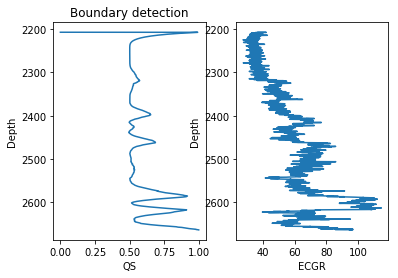

In [46]:
xx = pd.DataFrame(Petrophysical_data[['ECGR']])
QS = WeightQS2(np.array(xx)[0:3000], 0.2, 200, 50)


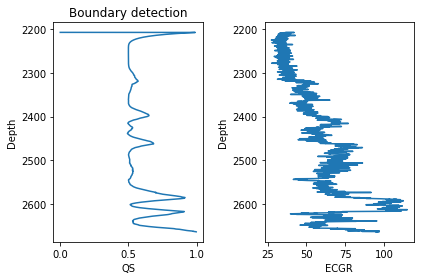

In [47]:
f1 = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(QS, np.array(Petrophysical_data['DEPTH'][0:3000]))
plt.gca().invert_yaxis()
plt.title('Boundary detection')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(np.array(Petrophysical_data['ECGR'][0:3000]), np.array(Petrophysical_data['DEPTH'][0:3000]))
plt.gca().invert_yaxis()
#plt.title('Boundary detection')
plt.xlabel('ECGR')
plt.ylabel('Depth')

f1.tight_layout()

## Now try for another variable 

In [52]:
x2 = pd.DataFrame(Petrophysical_data[['HART']])
QS2 = WeightQS2(np.array(x2)[1000:3000], 0.2, 200, 50)

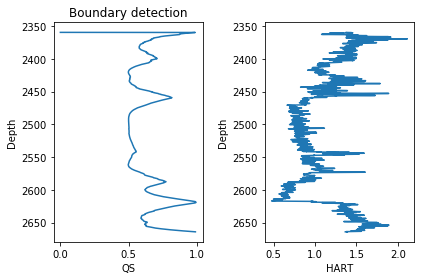

In [53]:
f1 = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(QS2, np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.title('Boundary detection')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(np.array(Petrophysical_data['HART'][1000:3000]), np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
#plt.title('Boundary detection')
plt.xlabel('HART')
plt.ylabel('Depth')

f1.tight_layout()

## Now combine the variables and use multivariate input

In [54]:
x3 = pd.DataFrame(Petrophysical_data[['HART','ECGR']])
QS2 = WeightQS2(np.array(x2)[1000:3000], 0.2, 200, 50)

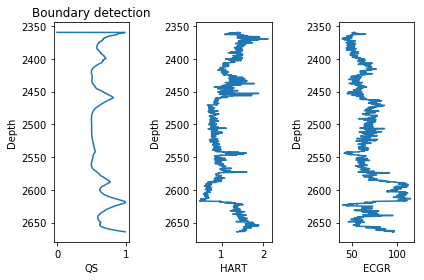

In [57]:
f2 = plt.figure()

plt.subplot(1, 3, 1)
plt.plot(QS2, np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
plt.title('Boundary detection')
plt.xlabel('QS')
plt.ylabel('Depth')

plt.subplot(1, 3, 2)
plt.plot(np.array(Petrophysical_data['HART'][1000:3000]), np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
#plt.title('Boundary detection')
plt.xlabel('HART')
plt.ylabel('Depth')

plt.subplot(1, 3, 3)
plt.plot(np.array(Petrophysical_data['ECGR'][1000:3000]), np.array(Petrophysical_data['DEPTH'][1000:3000]))
plt.gca().invert_yaxis()
#plt.title('Boundary detection')
plt.xlabel('ECGR')
plt.ylabel('Depth')

f2.tight_layout()